In [1]:
import cv2
import glob
from IPython.display import HTML
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from moviepy.editor import VideoFileClip
import numpy as np
from scipy.ndimage.measurements import label
from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
%matplotlib inline

In [2]:
images_car = glob.glob('vehicles/**/*.png')
images_noncar = glob.glob('non-vehicles/**/*.png')
print("Car amount = ", len(images_car), " and Noncar amount = ", len(images_noncar))

Car amount =  3425  and Noncar amount =  3900


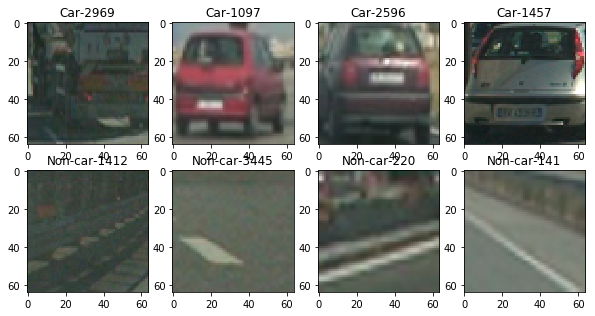

In [3]:
def show_examples():
    plt.figure(figsize=(10, 5))

    for i in range(4):
        random_car = np.random.randint(0, len(images_car))
        random_noncar = np.random.randint(0, len(images_noncar))

        car_image = mpimg.imread(images_car[random_car])
        notcar_image = mpimg.imread(images_noncar[random_noncar])

        plt.subplot(2, 4, i + 1)
        plt.imshow(car_image)
        plt.title('Car-' + str(random_car))
        plt.subplot(2, 4, i + 1 + 4)
        plt.imshow(notcar_image)
        plt.title('Non-car-' + str(random_noncar))


show_examples()

In [4]:
def histogrammer(img, nbins=32): # bins between 0 to 256
    chan1_hist = np.histogram(img[:, :, 0], bins=nbins)
    chan2_hist = np.histogram(img[:, :, 1], bins=nbins)
    chan3_hist = np.histogram(img[:, :, 2], bins=nbins)
    hist_features = np.concatenate((chan1_hist[0], chan2_hist[0], 
                                    chan3_hist[0]))
    return hist_features

In [5]:
def get_hog_feats(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    if vis == True:
        features, hog_image = hog(img, orientations=orient,
                            pixels_per_cell=(pix_per_cell, pix_per_cell),
                            cells_per_block=(cell_per_block, cell_per_block),
                            transform_sqrt=False,
                            visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    else:
        features = hog(img, orientations=orient,
                             pixels_per_cell=(pix_per_cell, pix_per_cell),
                             cells_per_block=(cell_per_block, cell_per_block),
                             transform_sqrt=False,
                             visualise=vis, feature_vector=feature_vec)
        return features

In [6]:
color_space = 'YUV'
hog_channel = 'ALL'
orient = 11
cell_per_block = 2
pix_per_cell = 16

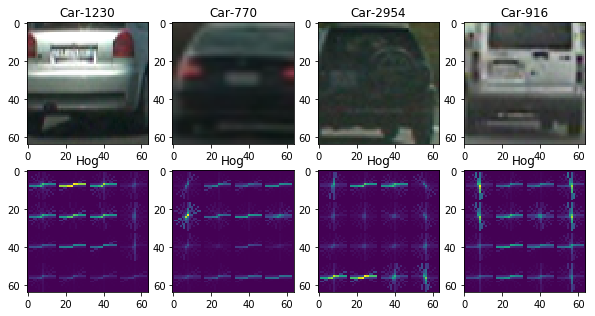

In [7]:
def show_hogs():
    plt.figure(figsize=(10, 5))

    for i in range(4):
        random_car = np.random.randint(0, len(images_car))
        random_noncar = np.random.randint(0, len(images_noncar))

        car_image = mpimg.imread(images_car[random_car])
        notcar_image = mpimg.imread(images_noncar[random_noncar])

        plt.subplot(2, 4, i + 1)
        plt.imshow(car_image)
        plt.title('Car-' + str(random_car))
        
        plt.subplot(2, 4, i + 1 + 4)
        feats, img_hog = get_hog_feats(car_image[:, :, 0],
                         orient, pix_per_cell, cell_per_block,
                         vis=True, feature_vec=True)
        plt.imshow(img_hog)
        plt.title('Hog')


show_hogs()

In [8]:
def extract_features(imgs, cspace='RGB', orient=9,
                    pix_per_cell=8, cell_per_block=2, hog_channel=0):
    feats = []
    for file in imgs:
        image = mpimg.imread(file)
        if cspace != 'RGB':
            if cspace == 'HSV':
                image_feat = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                image_feat = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                image_feat = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                image_feat = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                image_feat = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else:
            image_feat = np.copy(image)

        if hog_channel == 'ALL':
            hog_feats = []
            for channel in range(image_feat.shape[2]):
                hog_feats.append(get_hog_feats(image_feat[:, :, channel],
                                    orient, pix_per_cell, cell_per_block,
                                    feature_vec=True))
            hog_feats = np.ravel(hog_feats)
        else:
            hog_feats = get_hog_feats(image_feat[:, :, hog_channel], orient,
                                    pix_per_cell, cell_per_block, feature_vec=True)
        feats.append(hog_feats)
    return feats

In [9]:
# Parameters of feature extraction
color_space = 'YUV'
hog_channel = 'ALL'
orient = 11
cell_per_block = 2
pix_per_cell = 16

In [10]:
features_car = extract_features(images_car, cspace=color_space, orient=orient,
                                pix_per_cell=pix_per_cell, cell_per_block=cell_per_block,
                                hog_channel=hog_channel)
features_noncar = extract_features(images_noncar, cspace=color_space, orient=orient,
                                pix_per_cell=pix_per_cell, cell_per_block=cell_per_block,
                                hog_channel=hog_channel)
print('HOG features extracted.')

HOG features extracted.


In [11]:
X = np.vstack((features_car, features_noncar)).astype(np.float64)
y = np.hstack((np.ones(len(features_car)), np.zeros(len(features_noncar))))
# Split data into random training and test sets
rand_state = np.random.randint(0, 99)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=rand_state)
print('Hog properties:')
print('orient = ', orient)
print('pix_per_cell = ', pix_per_cell)
print('cell_per_block = ', cell_per_block)
print('Lenght of feature vector:', len(X_train[0]))

Hog properties:
orient =  11
pix_per_cell =  16
cell_per_block =  2
Lenght of feature vector: 1188


In [12]:
svc = LinearSVC()
svc.fit(X_train, y_train)
print('SVC accuracy = ', round(svc.score(X_test, y_test), 4))
n_predict = 10
print('Predictions: ', svc.predict(X_test[0:n_predict]))
print('Real data:   ', y_test[0:n_predict])

SVC accuracy =  0.9672
Predictions:  [ 0.  0.  0.  0.  1.  1.  1.  0.  1.  0.]
Real data:    [ 0.  0.  0.  0.  1.  1.  1.  0.  1.  0.]


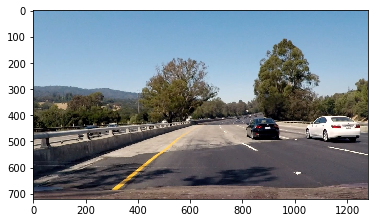

In [13]:
img_test = mpimg.imread('./test_images/test4.jpg')
img = img_test
plt.imshow(img_test)

In [14]:
ytop = 400
ybottom = 656
img_cropped = img[ytop:ybottom, :, :]
print('Original Shape =', img.shape)
print('Cropped Shape =', img_cropped.shape)

Original Shape = (720, 1280, 3)
Cropped Shape = (256, 1280, 3)


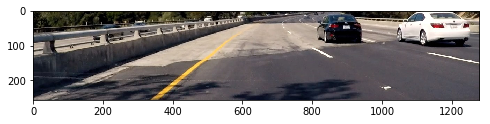

In [15]:
plt.figure(figsize=(8, 8))
plt.imshow(img_cropped)

In [16]:
def find_cars(img, ystart, ystop, scale, cspace, hog_channel, svc, X_scaler, orient, 
              pix_per_cell, cell_per_block, spatial_size, hist_bins, show_all_rectangles=False):
    
    rectangles = []
    
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]

    if cspace != 'RGB':
        if cspace == 'HSV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YUV)
        elif cspace == 'YCrCb':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YCrCb)
    else: ctrans_tosearch = np.copy(image)   
    
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
    
    if hog_channel == 'ALL':
        ch1 = ctrans_tosearch[:,:,0]
        ch2 = ctrans_tosearch[:,:,1]
        ch3 = ctrans_tosearch[:,:,2]
    else: 
        ch1 = ctrans_tosearch[:,:,hog_channel]

    nxblocks = (ch1.shape[1] // pix_per_cell)+1
    nyblocks = (ch1.shape[0] // pix_per_cell)+1
    nfeat_per_block = orient*cell_per_block**2
    
    window = 64
    nblocks_per_window = (window // pix_per_cell)-1 
    cells_per_step = 2
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    
    hog1 = get_hog_feats(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)   
    if hog_channel == 'ALL':
        hog2 = get_hog_feats(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog3 = get_hog_feats(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            if hog_channel == 'ALL':
                hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            else:
                hog_features = hog_feat1

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell
            
            test_prediction = svc.predict(hog_features)
            
            if test_prediction == 1 or show_all_rectangles:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                rectangles.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                
    return rectangles

In [17]:
ytop = 400
ybottom = 656
scale = 1.5
color_space = 'YUV'
hog_channel = 'ALL'
cell_per_block = 2
orient = 11
pix_per_cell = 16

In [18]:
rectangles = find_cars(img_test, ytop, ybottom, scale, color_space, hog_channel, svc, None, orient, pix_per_cell,
											 cell_per_block, None, None)

print(len(rectangles), 'rectangles found in image')

9 rectangles found in image


In [19]:
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    imcopy = np.copy(img)
    random_color = False
    for bbox in bboxes:
        if color == 'random' or random_color:
            color = (np.random.randint(0, 255), np.random.randint(0, 255), np.random.randint(0, 255))
            random_color = True
            cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    return imcopy

In [20]:
rects_img_test = draw_boxes(img_test, rectangles)

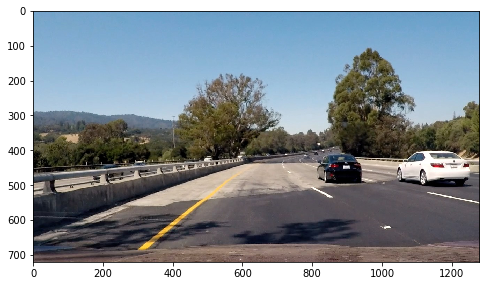

In [21]:
plt.figure(figsize=(8, 8))
plt.imshow(rects_img_test)

In [22]:
img_test = mpimg.imread('./test_images/test6.jpg')
rectangles = []
color_space = 'YUV'
hog_channel = 'ALL'
cell_per_block = 2
orient = 11
pix_per_cell = 16

In [23]:
ytop = 400
ybottom = 464
scale = 1.0
rectangles.append(find_cars(img_test, ytop, ybottom, scale, color_space, hog_channel, svc, None,
                    orient, pix_per_cell, cell_per_block, None, None))

In [24]:
ytop = 416
ybottom = 480
scale = 1.0
rectangles.append(find_cars(img_test, ytop, ybottom, scale, color_space, hog_channel, svc, None,
                    orient, pix_per_cell, cell_per_block, None, None))

In [25]:
ytop = 400
ybottom = 496
scale = 1.5
rectangles.append(find_cars(img_test, ytop, ybottom, scale, color_space, hog_channel, svc, None,
                    orient, pix_per_cell, cell_per_block, None, None))

In [26]:
ytop = 432
ybottom = 528
scale = 1.5
rectangles.append(find_cars(img_test, ytop, ybottom, scale, color_space, hog_channel, svc, None,
                    orient, pix_per_cell, cell_per_block, None, None))

In [27]:
ytop = 400
ybottom = 528
scale = 2.0
rectangles.append(find_cars(img_test, ytop, ybottom, scale, color_space, hog_channel, svc, None,
                    orient, pix_per_cell, cell_per_block, None, None))

In [28]:
ytop = 432
ybottom = 560
scale = 2.0
rectangles.append(find_cars(img_test, ytop, ybottom, scale, color_space, hog_channel, svc, None,
                    orient, pix_per_cell, cell_per_block, None, None))

In [29]:
ytop = 400
ybottom = 596
scale = 3.5
rectangles.append(find_cars(img_test, ytop, ybottom, scale, color_space, hog_channel, svc, None,
                    orient, pix_per_cell, cell_per_block, None, None))

In [30]:
ytop = 464
ybottom = 660
scale = 3.5
rectangles.append(find_cars(img_test, ytop, ybottom, scale, color_space, hog_channel, svc, None,
                    orient, pix_per_cell, cell_per_block, None, None))

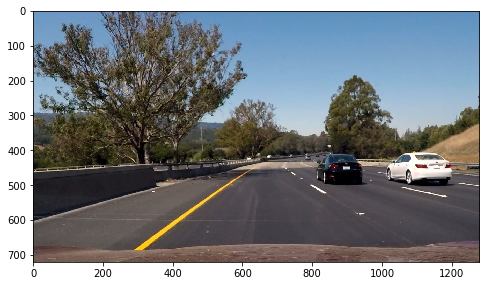

In [31]:
rectangles = [item for sublist in rectangles for item in sublist]
rects_img_test = draw_boxes(img_test, rectangles, thick=2)
plt.figure(figsize=(8, 8))
plt.imshow(rects_img_test)

In [32]:
def heatmapper(heatmap, bounding_box_list):
    for box in bounding_box_list:
        # ((x1, y1) to (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
    return heatmap

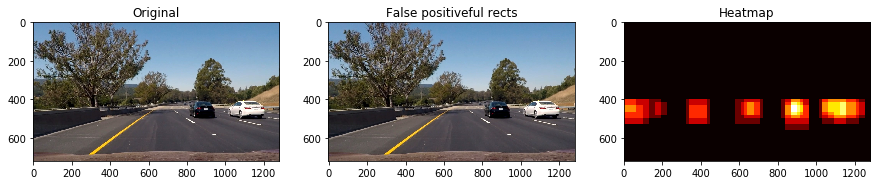

In [33]:
img_heatmap = np.zeros_like(img_test[:, :, 0])
img_heatmap = heatmapper(img_heatmap, rectangles)
plt.figure(figsize=(15, 15))
plt.subplot(131)
plt.title('Original')
plt.imshow(img_test)
plt.subplot(132)
plt.title('False positiveful rects')
plt.imshow(rects_img_test)
plt.subplot(133)
plt.title('Heatmap')
plt.imshow(img_heatmap, cmap='hot')

In [34]:
def heatmap_tresholder(heatmap, threshold):
    heatmap[heatmap <= threshold] = 0
    return heatmap

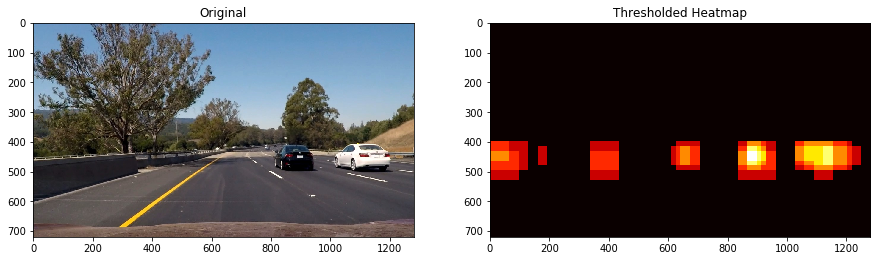

In [35]:
img_heatmap_threshold = heatmap_tresholder(img_heatmap, 1)
plt.figure(figsize=(15, 15))
plt.subplot(121)
plt.title('Original')
plt.imshow(img_test)
plt.subplot(122)
plt.title('Thresholded Heatmap')
plt.imshow(img_heatmap_threshold, cmap='hot')

6 cars found


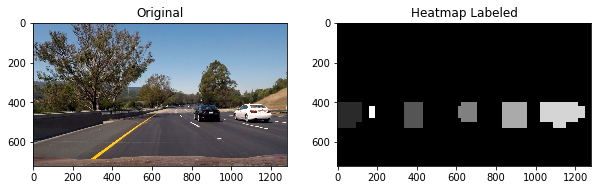

In [36]:
labels = label(img_heatmap)
plt.figure(figsize=(10, 10))
plt.figure(figsize=(10, 10))
plt.subplot(121)
plt.title('Original')
plt.imshow(img_test)
plt.subplot(122)
plt.title('Heatmap Labeled')
plt.imshow(labels[0], cmap='gray')
print(labels[1], 'cars found')

In [37]:
def draw_bboxes_labeled(img, labels):
    rects = []
    for car_current in range(1, labels[1] + 1):
        nonzero = (labels[0] == car_current).nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        bound_box = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        rects.append(bound_box)
        cv2.rectangle(img, bound_box[0], bound_box[1], (0, 0, 255), 6)
    return img, rects

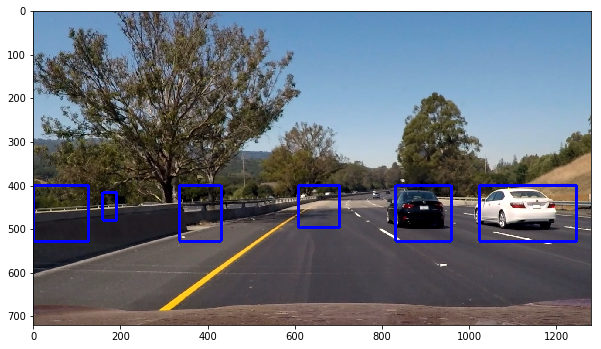

In [38]:
draw_img, rect = draw_bboxes_labeled(np.copy(img_test), labels)
plt.figure(figsize=(10, 10))
plt.imshow(draw_img)

In [39]:
def process_frame_final(img):
    rectangles = []

    colorspace = 'YUV'
    hog_channel = 'ALL'
    cell_per_block = 2
    orient = 11
    pix_per_cell = 16

    ytop = 400
    ybottom = 464
    scale = 1.0
    rectangles.append(find_cars(img, ytop, ybottom, scale, colorspace, hog_channel, svc, None,
                                                            orient, pix_per_cell, cell_per_block, None, None))
    ytop = 416
    ybottom = 480
    scale = 1.0
    rectangles.append(find_cars(img, ytop, ybottom, scale, colorspace, hog_channel, svc, None,
                                                            orient, pix_per_cell, cell_per_block, None, None))
    ytop = 400
    ybottom = 496
    scale = 1.5
    rectangles.append(find_cars(img, ytop, ybottom, scale, colorspace, hog_channel, svc, None,
                                                            orient, pix_per_cell, cell_per_block, None, None))
    ytop = 432
    ybottom = 528
    scale = 1.5
    rectangles.append(find_cars(img, ytop, ybottom, scale, colorspace, hog_channel, svc, None,
                                                            orient, pix_per_cell, cell_per_block, None, None))
    ytop = 400
    ybottom = 528
    scale = 2.0
    rectangles.append(find_cars(img, ytop, ybottom, scale, colorspace, hog_channel, svc, None,
                                                            orient, pix_per_cell, cell_per_block, None, None))
    ytop = 432
    ybottom = 560
    scale = 2.0
    rectangles.append(find_cars(img, ytop, ybottom, scale, colorspace, hog_channel, svc, None,
                                                            orient, pix_per_cell, cell_per_block, None, None))
    ytop = 400
    ybottom = 596
    scale = 3.5
    rectangles.append(find_cars(img, ytop, ybottom, scale, colorspace, hog_channel, svc, None,
                                                            orient, pix_per_cell, cell_per_block, None, None))
    ytop = 464
    ybottom = 660
    scale = 3.5
    rectangles.append(find_cars(img, ytop, ybottom, scale, colorspace, hog_channel, svc, None,
                                                            orient, pix_per_cell, cell_per_block, None, None))

    rectangles = [item for sublist in rectangles for item in sublist]

    if len(rectangles) > 0:
        a_vehicle.add_rects(rectangles)

    heatmap_img = np.zeros_like(img[:, :, 0])
    for rect_set in a_vehicle.old_rects:
        heatmap_img = heatmapper(heatmap_img, rect_set)
    heatmap_img = heatmap_tresholder(heatmap_img, 1 + len(a_vehicle.old_rects) // 2)

    labels = label(heatmap_img)
    draw_img, rect = draw_bboxes_labeled(np.copy(img), labels)
    return draw_img

In [40]:
class Vehicler():
    def __init__(self):
        # history of rectangles previous n frames
        self.old_rects = []

    def add_rects(self, new_rects):
        self.old_rects.append(new_rects)
        if len(self.old_rects) > 15:
            # throw out oldest rectangle set(s)
            self.old_rects = self.old_rects[len(self.old_rects) - 15:]

In [41]:
a_vehicle = Vehicler()
test_out_file_name = 'test_out.mp4'
clip_test = VideoFileClip('test_video.mp4')
clip_test_out = clip_test.fl_image(process_frame_final)
clip_test_out.write_videofile(test_out_file_name, audio=False)

[MoviePy] >>>> Building video test_out.mp4
[MoviePy] Writing video test_out.mp4


 97%|████████████████████████████████████████▉ | 38/39 [00:27<00:00,  1.53it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_out.mp4 



In [42]:
from IPython.display import HTML
HTML("""
<video width="640" height="360" controls>
  <source src="{0}">
</video>
""".format('test_out.mp4'))

In [43]:
a_vehicle = Vehicler()
proj_out_file_name = 'project_out.mp4'
clip_proj = VideoFileClip('project_video.mp4')
clip_proj_out = clip_proj.fl_image(process_frame_final)
clip_proj_out.write_videofile(proj_out_file_name, audio=False)

[MoviePy] >>>> Building video project_out.mp4
[MoviePy] Writing video project_out.mp4


100%|█████████████████████████████████████▉| 1260/1261 [18:56<00:01,  1.02s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_out.mp4 



In [44]:
from IPython.display import HTML
HTML("""
<video width="640" height="360" controls>
  <source src="{0}">
</video>
""".format('project_out.mp4'))